<a href="https://colab.research.google.com/github/Rbrut/Sentiment-Analysis/blob/main/SentimentAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Dataset**

The data is from kaggle, and it contains 50000 movie reviews labeled positive or negative.

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [17]:
# Loading the dataset into a pandas data frame
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/Dataset/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# **EDA**

In [19]:
# Dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [20]:
# Dataset description
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [21]:
# Sum null values
data.isna().sum()

review       0
sentiment    0
dtype: int64

In [22]:
# Duplicate values sum
data.duplicated().sum()

418

In [23]:
# Duplicated rows
duplicateRows = data[data.duplicated()]
duplicateRows

,review,sentiment
3537,Quite what the producers of this appalling ada...,negative
3769,My favourite police series of all time turns t...,positive
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive
6352,If you liked the Grinch movie... go watch that...,negative
6479,I want very much to believe that the above quo...,negative
...,...,...
49912,This is an incredible piece of drama and power...,positive
49950,This was a very brief episode that appeared in...,negative
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49986,This movie is a disgrace to the Major League F...,negative


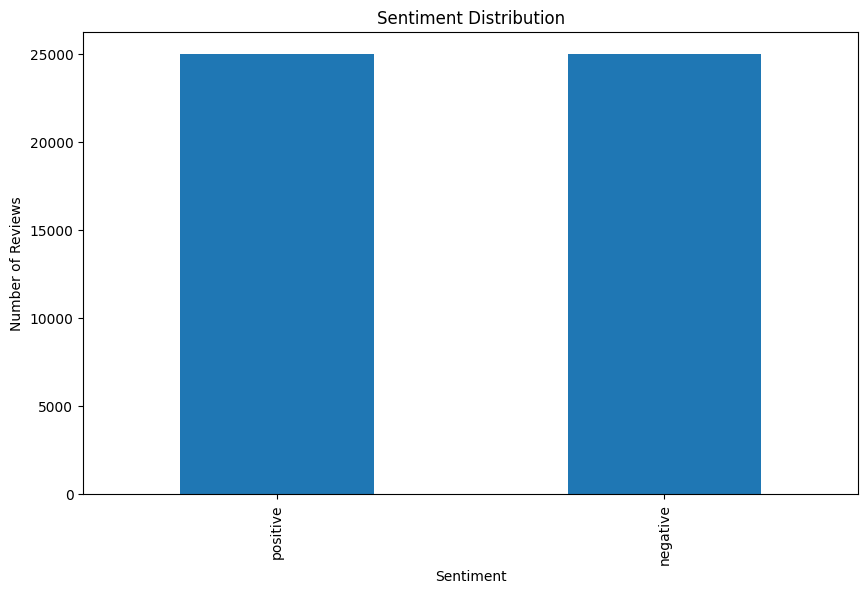

In [18]:
import matplotlib.pyplot as plt

#  Number of reviews for each sentiment
sentiment_counts = data['sentiment'].value_counts()

# Bar chart of sentiment count
sentiment_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
_ = plt.ylabel('Number of Reviews')

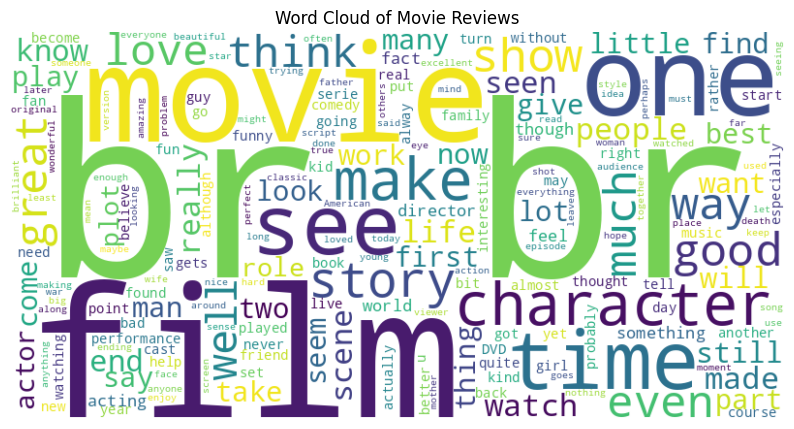

In [4]:
from wordcloud import WordCloud

# Rows with only positive sentiment
positive_reviews = data[data['sentiment'] == 'positive']
positive_reviews_text = ' '.join(positive_reviews['review'])

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Reviews')
plt.show()

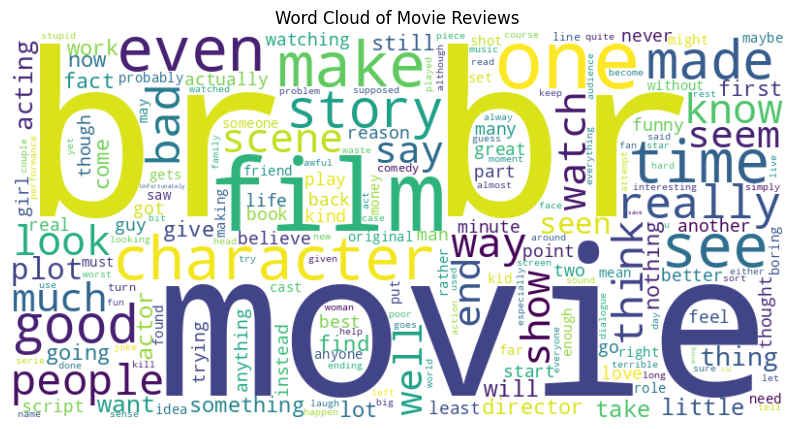

In [5]:
# Rows with only negative sentiment
negative_reviews = data[data['sentiment'] == 'negative']
negative_reviews_text = ' '.join(negative_reviews['review'])

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Reviews')
plt.show()

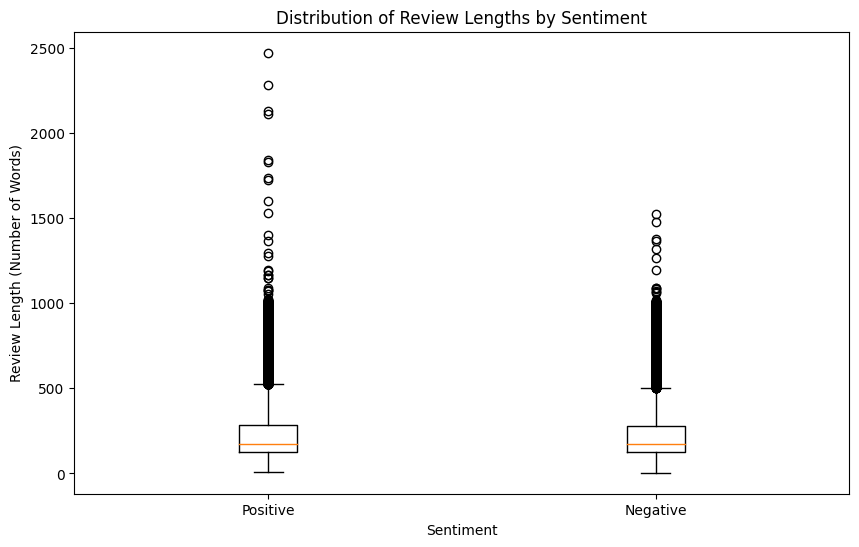

In [6]:
# Box plot of review lengths by sentiment category
data['review_length'] = data['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
plt.boxplot([data[data['sentiment'] == 'positive']['review_length'],
             data[data['sentiment'] == 'negative']['review_length']],
            labels=['Positive', 'Negative'])
plt.xlabel('Sentiment')
plt.ylabel('Review Length (Number of Words)')
plt.title('Distribution of Review Lengths by Sentiment')
plt.show()

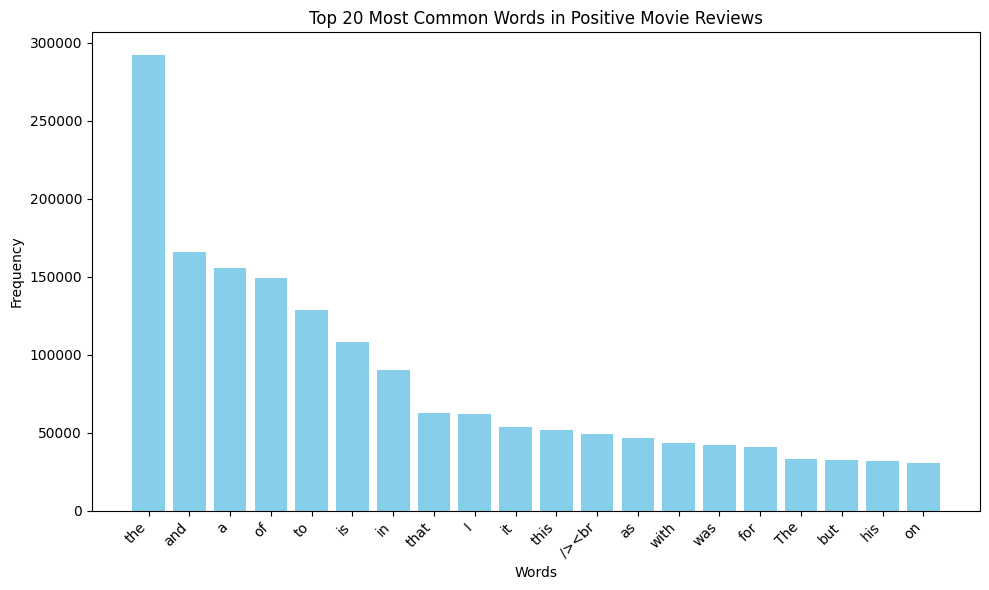

In [24]:
"""
this part helps in understanding the distribution
of words and identifying the most frequent terms used in the reviews.
"""
from collections import Counter

# Tokenize reviews and count word frequencies (positive sentiment)
words = positive_reviews_text.split()
word_freq = Counter(words)

# Bar plot of word frequencies (Top 20)
most_common_words = word_freq.most_common(20)
plt.figure(figsize=(10, 6))
plt.bar(*zip(*most_common_words), color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words in Positive Movie Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

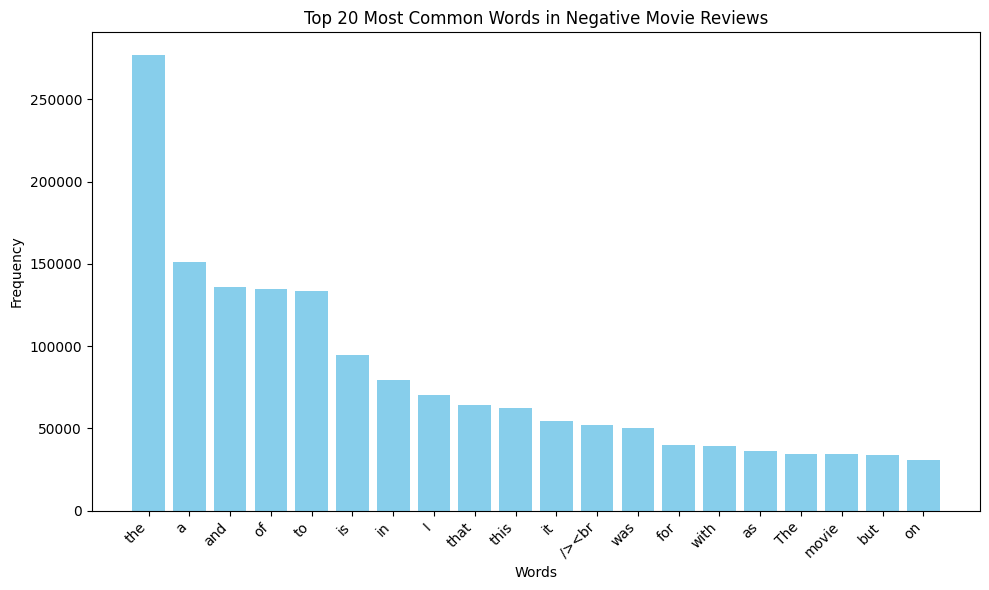

In [25]:
# Tokenize reviews and count word frequencies (negative sentiment)
words = negative_reviews_text.split()
word_freq = Counter(words)

# Bar plot of word frequencies (top 20)
most_common_words = word_freq.most_common(20)
plt.figure(figsize=(10, 6))
plt.bar(*zip(*most_common_words), color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words in Negative Movie Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# **DATA PREPARATION**

After exploring the dataset, we learn some valuable insight that will be used to guide the preprocessing steps. In this section, we'll create a preprocessing pipelline that will be used to clean the data. It will be applied specifically to ['review'] column. After cleaing the data, it will be split into training/and testing set, then it will be converted t a collection of matrix of token counts, using the default Countvectorizer() from sklearn.

In [5]:
# Libraries
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
#  converting the sentiment text labels to numerical form
# (1 for 'positive' and 0 for 'negative') using a lambda function with the apply() method.
data['sentiment'] = data['sentiment'].apply((lambda x: 1 if x == 'positive' else 0))

In [7]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [8]:
# Map english contractions to expanded form
contraction_mapping = {
    "aren't": "are not",
    "won't": "will not",
    "we'll": "we will",
    "i'll": "I will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "they'll": "they will",
    "can't": "can not",
    "couldn't": "could not",
    "don't": "do not",
    "doesn't": "does not",
    "haven't": "have not",
    "hasn't": "has not",
    "i'm": "i am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "that'll": "that will",
    "there'll": "there will",
    "mustn't": "must not",
    "who'll": "who will",
    "who's": "who is",
    "what's": "what is",
    "weren't": "were not",
    "we'd": "we would",
    "we've": "we have",
    "wasn't": "was not",
    "they've": "they have",
    "they're": "they are",
    "shouldn't": "should not",
    "he'd": "he would",
    "isn't": "is not"
}

In [9]:
# Preprocessing Step
# Data cleaning
""" removing noises such as special characters, numbers, punctuations, URL, HTML tags, ...
tokenizinig, removing stop words, and lemmatizing
expanding contractions """
# Load NLTK stopwords
stop_words = set(stopwords.words('english'))


# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to expand contractions
def expand_contractions(text, contraction_mapping):
    for contraction, expansion in contraction_mapping.items():
        text = text.replace(contraction, expansion)
    return text

# Function to clean text
def clean_text(text):
    # Remove HTML tags
    cleaned_text = re.sub(r'<.*?>', ' ', text)

    # Convert text to lowercase
    cleaned_text = cleaned_text.lower()  # You can skip this line if you want to preserve capitalization

    # Expand contractions
    cleaned_text = expand_contractions(cleaned_text, contraction_mapping)

    # Remove special characters (excluding alphanumeric and spaces)
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_text)

    # Handle URLs: Replace URLs with a placeholder (e.g., '<URL>')
    cleaned_text = re.sub(r'http\S+', '<URL>', cleaned_text)

    # Tokenize the text into words
    words = word_tokenize(cleaned_text)

    # Remove stopwords
    cleaned_words = [word for word in words if word not in stop_words]

    # Lemmatize the words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in cleaned_words]

    # Join the lemmatized words back into a string
    cleaned_review = ' '.join(lemmatized_words)

    return cleaned_review

# Apply the clean_text function to the 'reviews' column
data['cleanedd_review'] = data['review'].apply(clean_text)

# Display the cleaned reviews
data.head()

,review,sentiment,cleanedd_review
0,One of the other reviewers has mentioned that ...,1,one reviewer mentioned watching 1 oz episode h...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter matteis love time money visually stunni...


In [10]:
# Print the first review before prerocessing
print(data['review'].iloc[0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

In [11]:
# Print the first review after preprocessing
print(data['cleanedd_review'].iloc[0])

one reviewer mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show wouldnt dare forget pretty picture painted mainstream audience forget charm forget romanceoz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison exp

In [12]:
# Feature extraction
X = data['cleanedd_review']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (35000,) (35000,)
Testing set shape: (15000,) (15000,)


In [13]:
# Create CountVectorizer instance and fit_transform on training data
vectorizer = CountVectorizer()
train_bow = vectorizer.fit_transform(X_train)

# Transform testing data using the same vectorizer
test_bow = vectorizer.transform(X_test)

# Vocabulary (list of unique words)
vocabulary = vectorizer.get_feature_names_out()

# **Model**

In [20]:
# Libraries / Frameworks
import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix, classification_report
import tensorflow as tf
from tf_keras.models import Sequential
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.layers import Embedding, LSTM, Dense, Bidirectional
from tf_keras.preprocessing.sequence import pad_sequences

In [15]:
# Naive Bayes
"""
Naive Bayses is a simple probabilistic classifier based on Baye's theorem used for classification problem.
It make the assumption that the features are independent of each other.
NB classifier despite being a simple machine learning model, is widely used in text classification task.

How it Works:
Training: It learns the probabilities of different features given each class from the training data.
Prediction: To make prediction, it calculates the probability of each class given the features using Bayes' theorem
and selects the class with the highest probability
Evaluation metric: accuracy, F1-score, precicion, recall.
"""
# Train Naive Bayes (NB) model
nb_model = MultinomialNB()
nb_model.fit(train_bow, y_train)

# Evaluate models on testing data
nb_pred = nb_model.predict(test_bow)

 # Evaluate the model
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_precision = precision_score(y_test, nb_pred, pos_label=1, average='binary', zero_division=0)
nb_recall = recall_score(y_test, nb_pred, pos_label=1)
nb_f1 = f1_score(y_test, nb_pred, pos_label=1)

print("Accuracy: {:.2f}".format(nb_accuracy))
print("Precision: {:.2f}".format(nb_precision))
print("Recall: {:.2f}".format(nb_recall))
print("F1-score: {:.2f}".format(nb_f1))

# Classification report
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_pred))

Accuracy: 0.86
Precision: 0.87
Recall: 0.85
F1-score: 0.86
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      7411
           1       0.87      0.85      0.86      7589

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



In [17]:
# SVM
"""
Support Vector Machine supervised learning algorithm used for classification and regression tasks.
It finds the optimal hyperplane that best separates data points of different classes.

How it Works:
Training: SVM learns a hyperplane that maximizes the margin between the closest data points of the different classes.
Prediction: To predict the class of new data, SVM determines which side of the hyperplane it falls on and assigns the corresponding class label.
Evaluation metric: accuracy, F1-score, precicion, recall.
"""
# Train Support Vector Machine (SVM) model
svm_model = LinearSVC()
svm_model.fit(train_bow, y_train)

# Evaluate models on testing data
svm_pred = svm_model.predict(test_bow)

 # Evaluate the model
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred, pos_label=1, average='binary', zero_division=0)
svm_recall = recall_score(y_test, svm_pred, pos_label=1)
svm_f1 = f1_score(y_test, svm_pred, pos_label=1)

print("Accuracy: {:.2f}".format(svm_accuracy))
print("Precision: {:.2f}".format(svm_precision))
print("Recall: {:.2f}".format(svm_recall))
print("F1-score: {:.2f}".format(svm_f1))

# Classification report
print("Support Vector Machine Classification Report:")
print(classification_report(y_test, svm_pred))

Accuracy: 0.87
Precision: 0.87
Recall: 0.87
F1-score: 0.87
Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      7411
           1       0.87      0.87      0.87      7589

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [22]:
# Neural Networks: RNN (LSTM)
"""
Reccurent Neural Network (RNN)
Long Short Term Memory (LSTM)
 is a type of neural network designed to handle sequential data by retaining information from previous time steps.
It's made of loops that allow information to persist, making it suitable for tasks involving sequential dependencies.
Long Short-Term Memory (LSTM) is a variant of Recurrent Neural Networks designed to address the vanishing gradient problem.
It introduces specialized memory cells and gating mechanisms to better capture long-term dependencies in sequential data.
"""

# Feature extraction for the Deep Learning model
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Calculate vocab_size
vocab_size = len(tokenizer.word_index) + 1

# Convert text data to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Determine max_length
max_length = max(len(seq) for seq in train_sequences)

# Pad sequences (to ensure uniform length)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

print("Vocabulary Size:", vocab_size)
print("Maximum Sequence Length:", max_length)

Vocabulary Size: 125401
Maximum Sequence Length: 1432


In [23]:
# Model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
print(model.summary())

In [24]:
# Train model
history = model.fit(train_padded, y_train, epochs=50, validation_data=(test_padded, y_test))

# Evaluate model
loss, accuracy = model.evaluate(test_padded, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1432, 100)         12540100  
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12632901 (48.19 MB)
Trainable params: 12632901 (48.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/50
1094/1094 [==============================] - 244s 200ms/step - l

**Model performances:**

Naives Bayes: 86% accuracy

SVM: 87% accuracy

RNN: 87% accuracy

Based on these results, we can see that the three models performed well in the context on this project, with SVM and RNN achieving the highest accuracy slightly outperforming the Naive Bayes model.


**Future Work:**
- try differents preprocing techniques to see the impact on the models perfromances
- Fine-tune hyperparameters to optimize the models performances

References:

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

-https://www.tensorflow.org/text/tutorials/text_classification_rnn

- https://www.tensorflow.org/guide/keras/working_with_rnns

- https://scikit-learn.org/stable/modules/svm.html

- https://www.geeksforgeeks.org/support-vector-machine-algorithm/

- https://scikit-learn.org/stable/modules/naive_bayes.html
